# News Recommendation System Capstone Project

**Author:** V S S Anirudh Sharma

## Overview

This Jupyter notebook documents the implementation and analysis of a recommendation system for iPrint, an emerging media house in India. The objective is to personalize user experiences by recommending relevant news articles based on search history and preferences.

The project is divided into two main parts:

1. **Top 10 Relevant Article Recommendations:**
   - Impute rating values based on interaction types.
   - Extract English articles from the platform content.
   - Explore and analyze features in the data set.
   - Build recommendation techniques, including user-based collaborative filtering, item-based collaborative filtering, content-based filtering, ALS, and hybrid models.

2. **Top 10 Similar News Articles Recommendations:**
   - Track user clicks to understand new interests.
   - Implement different models for generating recommendations.
   - Experiment with hybrid models.
   - Evaluate the recommendations using appropriate metrics.
---
## Contents

1. **Data Pre-processing:**
   - Imputation of ratings.
   - Creation of 'consumer_interactions' dataset.
   - Extraction of English articles.

2. **Exploratory Data Analysis (EDA):**
   - Distribution analysis of various features.
   - Exploration of interaction types, locations, and languages.

3. **Recommendation Techniques:**
   - User-based Collaborative Filtering.
   - Item-based Collaborative Filtering.
   - Content-based Filtering.
   - ALS (Alternating Least Squares).
   - Hybrid Recommendation System.

4. **Model Evaluation:**
   - Use of RMSE, MAE, and precision@k metrics.
   - Evaluation of content-based models using TF-IDF scores.
   - Assessment of overall performance with global precision@k.
---   

## Conclusion and Next Steps

This notebook provides a comprehensive overview of the recommendation system development for iPrint. The implemented models and evaluations aim to enhance user engagement by offering personalized content recommendations.

Further iterations and improvements can be explored based on the insights gained during the analysis.

---

### Note 

Make sure to run the code cells sequentially for accurate results.

Ensure the following directory structure before running.
```
│   news_recommender.ipynb  
│
└───data
│   │   consumer_transanctions.csv
│   │   platform_content.csv
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from math import sqrt

## Load Ratings Data

In [3]:
ratings = pd.read_csv('data/consumer_transanctions.csv')

C:\Users\vssashar\AppData\Local\Temp\ipykernel_18488\4065438279.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv('data/consumer_transanctions.csv')


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72312 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       72312 non-null  int64 
 1   interaction_type      72312 non-null  object
 2   item_id               72312 non-null  int64 
 3   consumer_id           72312 non-null  int64 
 4   consumer_session_id   72312 non-null  object
 5   consumer_device_info  56918 non-null  object
 6   consumer_location     56907 non-null  object
 7   country               56918 non-null  object
dtypes: int64(3), object(5)
memory usage: 4.4+ MB


## EDA on Ratings

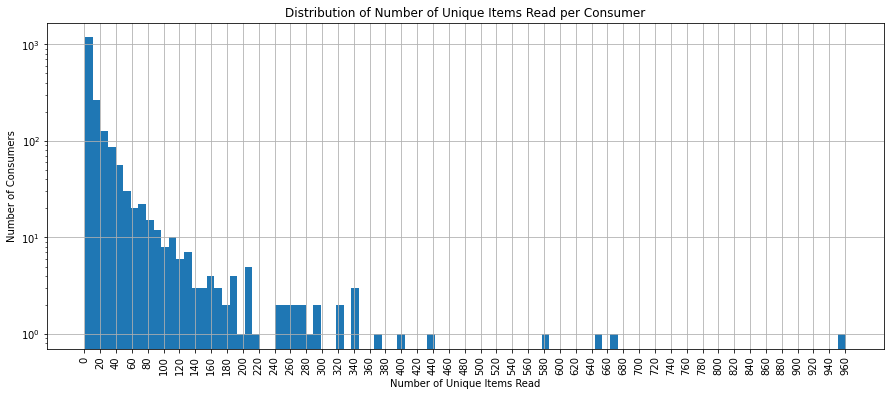

In [5]:
plt.figure(figsize=(15, 6))

# Group by 'consumer_id' and calculate the number of unique 'item_id' for each consumer
consumer_item_counts = ratings.groupby('consumer_id')['item_id'].nunique()

# Plot a distribution plot
plt.hist(consumer_item_counts,bins = 100)

# Set y-axis to log scale
plt.yscale('log')


# Increase frequency of x-axis ticks
plt.xticks(range(min(consumer_item_counts)-1, max(consumer_item_counts), 20))
plt.xticks(rotation=90)
plt.grid()

plt.title('Distribution of Number of Unique Items Read per Consumer')
plt.xlabel('Number of Unique Items Read')
plt.ylabel('Number of Consumers')
plt.show()

Most consumers have read less than 10 articles!

This suggests that our model better be prepared to make suggestions based on such small number of interactions.

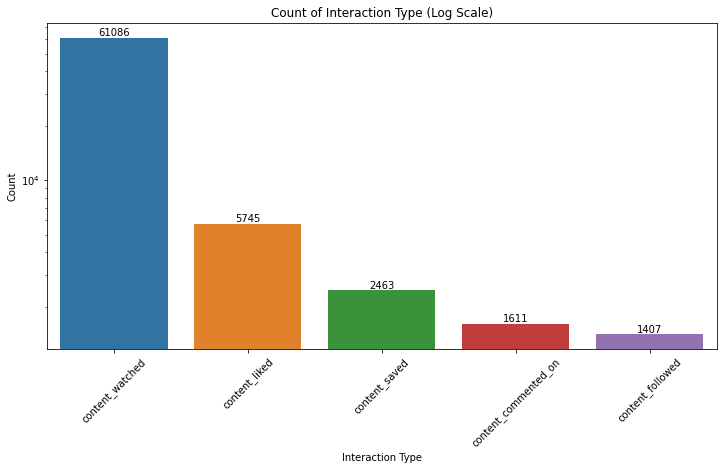

In [6]:
plt.figure(figsize=(12, 6))

# Create a count plot with seaborn
ax = sns.countplot(x='interaction_type', data=ratings, order=ratings['interaction_type'].value_counts().index)

# Set y-axis to log scale
plt.yscale('log')

# Annotate each bar with its count
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}',
            ha='center', va='bottom')

plt.title('Count of Interaction Type (Log Scale)')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We observe that there is substantial decrease in counts of content interactions from type to type.
This implies the following order of importance of each interaction in increasing order:
1. content_watched
2. content_liked
3. content_saved
4. content_commented_on
5. content_followed

This is in acceptance to our business understanding of increasing effort and interest from the user's side on each of these interactions

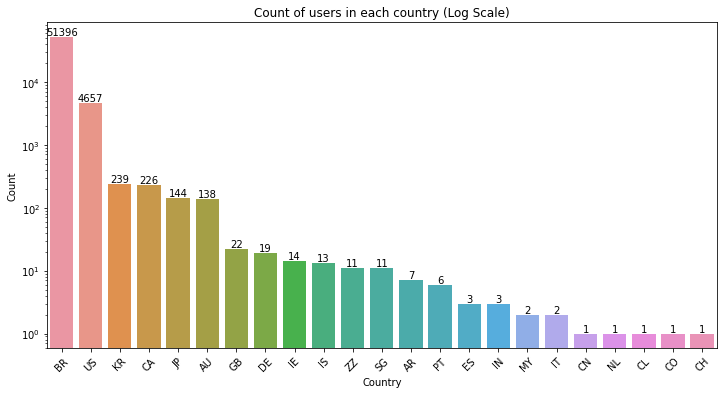

In [7]:
plt.figure(figsize=(12, 6))

# Create a count plot with seaborn
ax = sns.countplot(x='country', data=ratings, order=ratings['country'].value_counts().index)

# Set y-axis to log scale
plt.yscale('log')

# Annotate each bar with its count
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{int(p.get_height())}',
            ha='center', va='bottom')

plt.title('Count of users in each country (Log Scale)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Since iPrint is an Indian company, we may assume BR stands for Bharat. It would be an odd event if BR meant Brazil.

Going by our hypothesis, almost all users are from India, and we must note that the press seems to have a significant reach into US as well.

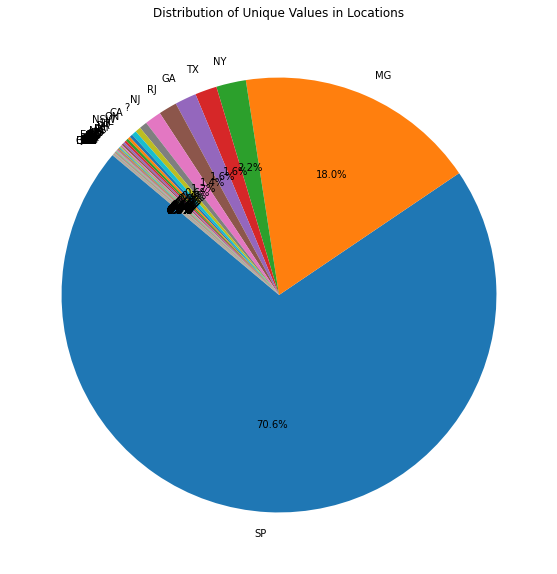

In [8]:
plt.figure(figsize=(10, 10))

# Calculate value counts for 'language'
location_counts = ratings['consumer_location'].value_counts()

# Plot a pie chart
patches, texts, autotexts = plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)

# Add a legend
# plt.legend(patches, location_counts.index, loc="best")

plt.title('Distribution of Unique Values in Locations')
plt.show()

71% of the users are from only one location SP. 
18% from SP.
Majority (almost 90%) of users are from these 2 locations, hinting us at the strong user localization.

## Removing pulled-out content from the system

In [9]:
news = pd.read_csv("data/platform_content.csv")

In [10]:
news.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [11]:
# Filter "ratings" DataFrame based on "item_id" in "news" with "interaction_type" == "content_present" and "language" == "en"
filtered_ratings = ratings[ratings['item_id'].abs().isin(news.loc[(news['interaction_type'] == 'content_present')&(news['language'] == 'en'), 'item_id'].abs())]


In [12]:
ratings = filtered_ratings

In [13]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47041 entries, 0 to 72311
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       47041 non-null  int64 
 1   interaction_type      47041 non-null  object
 2   item_id               47041 non-null  int64 
 3   consumer_id           47041 non-null  int64 
 4   consumer_session_id   47041 non-null  object
 5   consumer_device_info  36862 non-null  object
 6   consumer_location     36853 non-null  object
 7   country               36862 non-null  object
dtypes: int64(3), object(5)
memory usage: 3.2+ MB


## Ratings preprocessing
We need to map user interactions to numerical ratings.
Let us map the weightages proportional to the inverse of the frequency
<!-- 
Here, we shall assign the following rating to each interaction type, and per user-item combo, pick the maximum value as its rating:
| interaction_type    | rating |
| -------- | ------- |
| content_watched  | 1    |
| content_liked | 2    |
| content_saved    | 3    |
| content_commented_on | 4    |
| content_followed    | 5  | -->



In [14]:
ratings.interaction_type.unique()

array(['content_watched', 'content_liked', 'content_commented_on',
       'content_followed', 'content_saved'], dtype=object)

In [15]:
interaction_counts = dict(ratings['interaction_type'].value_counts())
print(interaction_counts)
total_interactions = sum(interaction_counts.values())
print('total interactions = ',total_interactions)

{'content_watched': 39823, 'content_liked': 3431, 'content_saved': 1847, 'content_commented_on': 1038, 'content_followed': 902}
total interactions =  47041


In [16]:
inverse_interaction_weights = {interaction:1/interaction_counts[interaction] for interaction in interaction_counts}
max_inverse_interaction_weights = max(inverse_interaction_weights.values())

In [17]:
# interaction_2_rating = {interaction:total_interactions/interaction_counts[interaction] for interaction in interaction_counts}
interaction_2_rating = {interaction:inverse_interaction_weights[interaction]/max_inverse_interaction_weights for interaction in interaction_counts}

In [18]:
interaction_2_rating

{'content_watched': 0.022650227255606056,
 'content_liked': 0.2628971145438648,
 'content_saved': 0.48835950189496485,
 'content_commented_on': 0.8689788053949904,
 'content_followed': 1.0}

In [19]:
ratings['rating'] = ratings.interaction_type.apply(lambda x: interaction_2_rating[x])

In [20]:
#Let us check if we can retain only the abslute value of consumer_id
print(ratings.consumer_id.nunique())
print(ratings.consumer_id.apply(abs).nunique())

1644
1644


In [21]:
# Which implies that we can keep the absolute values of ids
ratings.consumer_id = ratings.consumer_id.apply(abs)

In [22]:
#Let us check if we can retain only the abslute value of consumer_id
print(ratings.item_id.nunique())
print(ratings.item_id.apply(abs).nunique())

2149
2149


In [23]:
# Which implies that we can keep the absolute values of ids
ratings.item_id = ratings.item_id.apply(abs)


In [24]:
ratings.nunique()

event_timestamp         44782
interaction_type            5
item_id                  2149
consumer_id              1644
consumer_session_id     19295
consumer_device_info      917
consumer_location          69
country                    22
rating                      5
dtype: int64

In [25]:
# Find the maximum rating for each unique combination of 'item_id' and 'consumer_id'
ratings = ratings.groupby(['item_id', 'consumer_id'])['rating'].max().reset_index()


In [26]:
ratings.shape

(26193, 3)

In [27]:
# we shall take forward only the required columns
ratings = ratings[['item_id','consumer_id','rating']]

In [28]:
ratings.head()

,item_id,consumer_id,rating
0,1523691178084871,48161796606086482,0.48836
1,1523691178084871,510621402112686165,0.02265
2,1523691178084871,2626634673110551643,1.00000
3,1523691178084871,3813842765808990208,0.02265
4,1523691178084871,3978390417378743562,0.02265


In [29]:
ratings.describe()

,item_id,consumer_id,rating
count,2.619300e+04,2.619300e+04,26193.000000
mean,4.711392e+18,4.259374e+18,0.112403
std,2.635695e+18,2.691049e+18,0.221829
min,1.523691e+15,9.503310e+15,0.022650
25%,2.539916e+18,1.895326e+18,0.022650
50%,4.707863e+18,3.659019e+18,0.022650
75%,6.941293e+18,6.644119e+18,0.022650
max,9.222265e+18,9.223122e+18,1.000000


In [30]:
n_users = ratings.consumer_id.nunique()

n_items = ratings.item_id.nunique()

In [31]:
n_users

1644

In [32]:
n_items

2149

### Test Train Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train, test = train_test_split(ratings, train_size=0.8, random_state=42)

In [35]:
dummy_train = train.copy()
dummy_train

,item_id,consumer_id,rating
11674,4189221198175710203,2901546026085255870,0.022650
8341,3091351089612339864,3508202263850468997,0.022650
23589,8427763028519233712,3390049372067052505,0.022650
1097,456574518348806233,1443636648652872475,0.022650
4291,1625815289565836489,3474152259371895547,0.022650
...,...,...,...
21575,7623502978685822577,7656701953949775820,0.022650
5390,2097075598039554565,3649923015832992113,0.262897
860,363798057559041921,1443636648652872475,0.022650
15795,5533752987392101383,5230721907253934520,0.022650


In [36]:
#unseen items rated as content watched
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>= interaction_2_rating['content_watched'] else 1)
dummy_train = dummy_train.pivot(index = 'consumer_id',columns = 'item_id').fillna(interaction_2_rating['content_watched'])

## Create Pivot Matrix from rating values

In [37]:
data_matrix = train.pivot(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

In [38]:
data_matrix.head()

item_id,1523691178084871,2871288807409592,10247031220756478,14569272361926584,18930987176089166,21036008762564671,23817016428727099,30461094217357731,31349081826574004,33740349536513960,...,9189659052158407108,9190737901804729417,9192549002213406534,9207286802575546269,9208127165664287660,9209629151177723638,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
9503309754973814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13723062087756322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19128711904675838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22763587941636338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27448098970818567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
consumer_ids = data_matrix.T.columns
item_ids = data_matrix.columns


In [40]:
data_matrix.shape

(1554, 2103)

# USER BASED COLLABORATIVE FILTER (UBCF) RECOMMENDER

### Pairwise Distance

### consumer pairwise similarity distance

In [41]:
data_matrix

item_id,1523691178084871,2871288807409592,10247031220756478,14569272361926584,18930987176089166,21036008762564671,23817016428727099,30461094217357731,31349081826574004,33740349536513960,...,9189659052158407108,9190737901804729417,9192549002213406534,9207286802575546269,9208127165664287660,9209629151177723638,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
9503309754973814,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13723062087756322,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19128711904675838,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22763587941636338,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27448098970818567,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9199575329909162940,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9207251133131336884,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9210530975708218054,0.0,0.0,0.0,0.48836,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
consumer_ids = data_matrix.T.columns
item_ids = data_matrix.columns


In [43]:
data_matrix.shape

(1554, 2103)

In [44]:
from sklearn.metrics.pairwise import pairwise_distances 

In [45]:

user_similarity = 1- pairwise_distances(data_matrix, metric='cosine')


In [46]:
user_similarity

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.00181789],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00181789, 0.        ,
        1.        ]])

In [47]:
user_similarity[np.isnan(user_similarity)]=0

In [48]:
user_similarity.shape

(1554, 1554)

## Prediction: User-User

In [49]:
user_similarity[(user_similarity)<0]=0

In [50]:
user_predicted_rating  = np.dot(user_similarity,data_matrix.fillna(0))
user_predicted_rating

array([[5.24437635e-03, 1.18786316e-04, 0.00000000e+00, ...,
        1.18786316e-04, 5.37016860e-03, 0.00000000e+00],
       [0.00000000e+00, 5.17154794e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.48876897e-03, 3.26971246e-03, 6.54253908e-04, ...,
        1.17782958e-03, 5.30550969e-03, 2.76705534e-03],
       ...,
       [4.47208256e-03, 5.99250639e-04, 1.27781215e-04, ...,
        6.46812816e-05, 4.30402617e-03, 1.28336891e-03],
       [4.95514134e-04, 1.45819523e-05, 0.00000000e+00, ...,
        1.01590507e-05, 5.30450738e-03, 2.75295439e-05],
       [4.73489935e-03, 4.92203164e-02, 7.78307272e-04, ...,
        1.19743605e-04, 9.09662036e-03, 9.88306208e-04]])

In [51]:
user_predicted_rating.shape

(1554, 2103)

In [52]:
dummy_train.shape

(1554, 2103)

In [53]:
# since we are interested only in the new items not rated by the user, 
# we will ignore the movies rated by making setting user rated ones 0
user_final_rating = np.multiply(user_predicted_rating,dummy_train)
user_final_rating

rating                      \
item_id             1523691178084871    2871288807409592      
consumer_id                                                   
9503309754973814               0.000119        2.690537e-06   
13723062087756322              0.000000        1.171367e-06   
19128711904675838              0.000102        7.405973e-05   
22763587941636338              0.002040        3.845505e-03   
27448098970818567              0.000000        0.000000e+00   
...                                 ...                 ...   
9199575329909162940            0.000056        2.425689e-03   
9207251133131336884            0.000025        1.019362e-04   
9210530975708218054            0.000101        1.357316e-05   
9212075797126931087            0.000011        3.302845e-07   
9223121837663643404            0.000107        1.114851e-03   

                                                             \
item_id             10247031220756478   14569272361926584     
consumer_id                                                   
9503309754973814               0.000000            0.001731   
13723062087756322              0.000000            0.000000   
19128711904675838              0.000015            0.002053   
22763587941636338              0.000111            0.000305   
27448098970818567              0.000000            0.000000   
...                                 ...                 ...   
9199575329909162940            0.000000            0.000127   
9207251133131336884            0.000021            0.002843   
9210530975708218054            0.000003            0.000000   
9212075797126931087            0.000000            0.000044   
9223121837663643404            0.000018            0.000416   

                                                             \
item_id             18930987176089166   21036008762564671     
consumer_id                                                   
9503309754973814               0.000135            0.000008   
13723062087756322              0.000000            0.000000   
19128711904675838              0.000126            0.000173   
22763587941636338              0.000147            0.004137   
27448098970818567              0.000000            0.000003   
...                                 ...                 ...   
9199575329909162940            0.000002            0.003707   
9207251133131336884            0.000144            0.000241   
9210530975708218054            0.000166            0.000299   
9212075797126931087            0.000018            0.000006   
9223121837663643404            0.000126            0.001449   

                                                             \
item_id             23817016428727099   30461094217357731     
consumer_id                                                   
9503309754973814           0.000000e+00            0.000000   
13723062087756322          0.000000e+00            0.000000   
19128711904675838          0.000000e+00            0.000005   
22763587941636338          3.190452e-06            0.000034   
27448098970818567          0.000000e+00            0.000003   
...                                 ...                 ...   
9199575329909162940        0.000000e+00            0.000002   
9207251133131336884        0.000000e+00            0.000008   
9210530975708218054        2.172438e-06            0.000037   
9212075797126931087        3.604960e-07            0.000006   
9223121837663643404        1.833196e-05            0.000052   

                                                             ...  \
item_id             31349081826574004   33740349536513960    ...   
consumer_id                                                  ...   
9503309754973814               0.000055        3.937744e-06  ...   
13723062087756322              0.000000        0.000000e+00  ...   
19128711904675838              0.000014        1.271726e-03  ...   
22763587941636338              0.000082        1.437226e-04  ...   
27448098970818567        

### Finding top 10 recommendations for the consumer

In [54]:
# Group by 'consumer_id' and calculate the number of unique 'item_id' for each consumer
consumer_item_counts = ratings.groupby('consumer_id')['item_id'].nunique()

In [55]:
consumer_item_counts[consumer_item_counts<=30].sort_values(ascending=False)

consumer_id
7591088849912178995    30
7020155836312304353    30
520352373907677790     30
5375964707198876331    30
8841741572929644986    30
                       ..
7499921743426045629     1
5680079885186766579     1
7472538368234044044     1
1690554517720703181     1
3322908086840558280     1
Name: item_id, Length: 1467, dtype: int64

In [56]:
consumer_id = 7591088849912178995 #first in the above list of under 30 articles read
n_recs = 10

In [57]:
news = pd.read_csv('data/platform_content.csv')
news.item_id = news.item_id.apply(abs)

In [58]:
item_recommendation = user_final_rating.loc[consumer_id].sort_values(ascending = False)
item_recommendation = pd.merge(item_recommendation,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
item_recommendation.columns = ['item_id','score','title']

# Min-Max Scaling
min_score = min(item_recommendation['score'])
max_score = max(item_recommendation['score'])

normalized_ibcf_scores = (item_recommendation['score'] - min_score) / (max_score - min_score)

item_recommendation['normalized_ubfc_score'] = normalized_ibcf_scores


# Filter item_recommendation to include only items not in the ratings for the specified consumer_id
filtered_item_recommendation = item_recommendation[~item_recommendation.index.isin(ratings[ratings['consumer_id'] == consumer_id]['item_id'])]

print(f'Top 10 items recommended for consumer_id {consumer_id}:')
filtered_item_recommendation.head(n_recs)

Top 10 items recommended for consumer_id 7591088849912178995:


,item_id,score,title,normalized_ubfc_score
0,764116021156146784,0.007382,If you think women in tech is just a pipeline ...,1.000000
1,1878128207048892154,0.007278,The Ten Commandments of Egoless Programming,0.985857
2,8208801367848627943,0.006618,Ray Kurzweil: The world isn't getting worse - ...,0.896462
3,78667914647336721,0.005443,Build Quality In: The Key to Continuous Delive...,0.737381
4,5605799891597699962,0.005136,Concrete things you can do about your technica...,0.695676
5,205193648629294862,0.005074,Is FinTech Forcing Banking to a Tipping Point?,0.687392
6,1469580151036142903,0.004546,Don't document your code. Code your documentat...,0.615796
7,3206777048078326150,0.004470,Google IO 2016: A look at how not to run a lar...,0.605550
8,6156751702010469220,0.004446,The Broken Window Theory,0.602270
9,3870325027932266414,0.004333,Customize your G Suite experience with App Mak...,0.587022


### Evaluation on this particular recommendation

In [59]:
pred_set = list(filtered_item_recommendation.head(n_recs)['item_id'])

In [60]:
pred_set

[764116021156146784,
 1878128207048892154,
 8208801367848627943,
 78667914647336721,
 5605799891597699962,
 205193648629294862,
 1469580151036142903,
 3206777048078326150,
 6156751702010469220,
 3870325027932266414]

In [61]:
min_interaction_type = 'content_liked'
ratings_filtered = ratings[(ratings['consumer_id']==consumer_id) & (ratings['rating']>=interaction_2_rating[min_interaction_type])].sort_values(by='rating',ascending=False)

In [62]:
relevant_recommendations = pd.merge(ratings_filtered,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')

In [63]:
relevant_recommendations

,item_id,consumer_id,rating,title
0,2549933363319068481,7591088849912178995,0.488360,The real reasons you procrastinate - and how t...
1,4084131344684656470,7591088849912178995,0.488360,The Children's Illustrated Guide to Kubernetes
2,5037221949349729844,7591088849912178995,0.488360,Susan Wojcicki on the Effectiveness of Empower...
3,8483892789913825147,7591088849912178995,0.488360,Cookbook
4,8511291357261863413,7591088849912178995,0.488360,Dark Scrum
5,569574447134368517,7591088849912178995,0.262897,Mastering Bash and Terminal
6,1639450243805666792,7591088849912178995,0.262897,Rating the English Proficiency of Countries an...
7,2417383163258637695,7591088849912178995,0.262897,"""Eat, sleep, code, repeat"" is such bullshit - ..."
8,3495098006178009360,7591088849912178995,0.262897,A Googler analyzed a billion files to settle t...


In [64]:
relevant_set = ratings_filtered['item_id'].values

In [65]:
relevant_set

array([2549933363319068481, 4084131344684656470, 5037221949349729844,
       8483892789913825147, 8511291357261863413,  569574447134368517,
       1639450243805666792, 2417383163258637695, 3495098006178009360],
      dtype=int64)

In [66]:
precision_at_10 = len(list(set(relevant_set) & set(pred_set)))/10

In [67]:
precision_at_10

0.0

We observe a zero precision in this case. But this is owing to the extremely large number of articles, from which it would be a low probabilty event to match within 10 guesses. But we can observe how the titles of articles read by consumer are very close to the recommendations made. This implies that our model has subjectively done a great job, despite the low emperical evaluation based evidence

## Global Evaluation: User-User

In [68]:
common = test[test.consumer_id.isin(train.consumer_id)]
common.shape

(5132, 3)

In [69]:
common.head()

,item_id,consumer_id,rating
7949,2990005046938769485,6153009241569363021,0.02265
4972,1926525896637230556,692689608292948411,0.02265
24759,8757701761088346244,1317292353478724560,0.02265
4471,1674373276159762025,3609194402293569455,0.02265
5535,2134259819148812594,1352064057049251194,0.02265


In [70]:
print('total unique consumers in test dataset = ',test.consumer_id.nunique())
print('total unique consumers in test dataset common to training dataset = ',common.consumer_id.nunique())

total unique consumers in test dataset =  1035
total unique consumers in test dataset common to training dataset =  945


In [71]:
common_user_based_matrix = common.pivot_table(index = 'consumer_id',
                                              columns = 'item_id',
                                              values = 'rating')

In [72]:
common_user_based_matrix

item_id,1523691178084871,9178250635927683,14569272361926584,18930987176089166,21036008762564671,23817016428727099,30461094217357731,33740349536513960,36844712915106340,44082375822273498,...,9171475473795142532,9189659052158407108,9190737901804729417,9192549002213406534,9207286802575546269,9208127165664287660,9209629151177723638,9215261273565326920,9217155070834564627,9220445660318725468
consumer_id,,,,,,,,,,,,,,,,,,,,,
9503309754973814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13723062087756322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22763587941636338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35428957105270993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41506117647079716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.02265,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9191849144618614467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9199575329909162940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9210530975708218054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
#Convert the user_similarity matrix into dataframe

# Check if the size of the user_similarity_matrix_data matches the size of consumer_ids
assert len(consumer_ids) == len(user_similarity[0]), "Size mismatch between consumer_ids and user_similarity_matrix_data"
assert len(consumer_ids) == len(user_similarity), "Size mismatch between consumer_ids and user_similarity_matrix_data columns"

# Create a DataFrame
user_similarity_df = pd.DataFrame(data=user_similarity, index=consumer_ids, columns=consumer_ids)


In [74]:
user_similarity_df 

consumer_id,9503309754973814,13723062087756322,19128711904675838,22763587941636338,27448098970818567,35428957105270993,41506117647079716,48161796606086482,54023883492884059,57558373945119606,...,9187866633451383747,9188188261933657343,9191849144618614467,9196668942822132778,9199170757466086545,9199575329909162940,9207251133131336884,9210530975708218054,9212075797126931087,9223121837663643404
consumer_id,,,,,,,,,,,,,,,,,,,,,
9503309754973814,1.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13723062087756322,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19128711904675838,0.0,0.0,1.000000,0.011356,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.288675,0.000000,0.706347,0.000000,0.000000,0.000000
22763587941636338,0.0,0.0,0.011356,1.000000,0.000000,0.006696,0.0,0.155526,0.0,0.0,...,0.0,0.0,0.006556,0.000000,0.006556,0.006070,0.016043,0.000367,0.000000,0.005115
27448098970818567,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.046330,0.000000,0.992659,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9199575329909162940,0.0,0.0,0.000000,0.006070,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.030096
9207251133131336884,0.0,0.0,0.706347,0.016043,0.046330,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.407810,0.000000,1.000000,0.000000,0.045990,0.000000
9210530975708218054,0.0,0.0,0.000000,0.000367,0.000000,0.001926,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.011415,0.000000,0.000000,0.000000,1.000000,0.000000,0.001818


In [75]:
common.consumer_id.nunique()

945

In [76]:
#let us filter only those consumers into the similarity matrix, who are present in the common list
common_consumer_list = common.consumer_id.tolist()

user_similarity_df_1 = user_similarity_df[user_similarity_df.index.isin(common_consumer_list)]
user_similarity_df_2 = user_similarity_df_1.T[user_similarity_df_1.T.index.isin(common_consumer_list)]
user_similarity_df_3 = user_similarity_df_2.T

In [77]:
print(user_similarity_df_3.shape)
print(common_user_based_matrix.shape)

(945, 945)
(945, 1592)


In [78]:
#postprocess over the similarity matrix
user_similarity_df_3[user_similarity_df_3<0] = 0
common_user_predicted_matrix = np.dot(user_similarity_df_3,common_user_based_matrix.fillna(0))
common_user_predicted_matrix.shape

(945, 1592)

In [79]:
# we shall create a mask to predict those cases where already prediction done
dummy_test = common.copy()
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>0 else 0 )
dummy_test = dummy_test.pivot_table(index = 'consumer_id', columns = 'item_id',values='rating').fillna(0)

In [80]:
dummy_test.shape

(945, 1592)

In [81]:
common_user_predicted_rating = np.multiply(common_user_predicted_matrix,dummy_test)

### RMSE
Calculating the RMSE for only the articles rated by the consumer. For RMSE, normalizing the ratings between the min and max of our rating weights

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [83]:
X = common_user_predicted_rating.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(min(interaction_2_rating.values()),max(interaction_2_rating.values())))
print(scaler.fit(X))
y = scaler.transform(X)
print(y)

MinMaxScaler(feature_range=(0.022650227255606056, 1.0))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [84]:
common_ = common.pivot_table(index = 'consumer_id',columns='item_id',values='rating')

In [85]:
common_.shape, y.shape

((945, 1592), (945, 1592))

In [86]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()]
    ground_truth = ground_truth[ground_truth.nonzero()]
    return sqrt(mean_squared_error(prediction, ground_truth))

In [87]:

rmse(np.array(y),np.array(common_.fillna(0)))

0.38179732958352364

### MAE

In [88]:
def mae(prediction, ground_truth):

    prediction = prediction[ground_truth.nonzero()]
    
    ground_truth = ground_truth[ground_truth.nonzero()]
    
    return mean_absolute_error(prediction, ground_truth)

In [89]:

mae(np.array(y),np.array(common_.fillna(0)))

0.20786533725482756

### PRECISION @ K

In [90]:

def precision_at_k(predictions, ground_truth, k = 10):
    """
    Calculate Precision@K for a recommender system.

    Parameters:
    - predictions: 2D array, predicted ratings matrix
    - ground_truth: 2D array, actual ratings (ground truth) matrix
    - k: int, number of top elements to consider

    Returns:
    - Precision@K
    """
    precision_values = []

    for i in range(len(predictions)):
        # Get the indices of the top k predicted ratings
        top_k_indices = np.argsort(-predictions[i,:])[:k]

        # Extract the corresponding values from both prediction and ground truth
        # top_k_predictions = predictions[i][top_k_indices]
        top_k_ground_truth = ground_truth[i,:][top_k_indices]

        # Count the number of relevant items in the top K predictions
        num_relevant_in_top_k = np.sum(top_k_ground_truth > 0)

        # Calculate precision at K
        precision_at_k = num_relevant_in_top_k / k if k > 0 else 0.0
        precision_values.append(precision_at_k)

    # Calculate average precision across all users
    precision = np.mean(precision_values) if precision_values else 0.0

    return precision

In [91]:
precision_at_k(np.array(y),np.array(common_.fillna(0)),10)

0.36000000000000004

### MAP @ K

In [92]:
import numpy as np

def precision_at_k_1(predictions, ground_truth, k=10):
    """
    Calculate Precision@K for a single user.

    Parameters:
    - predictions: 1D array, predicted ratings for a user
    - ground_truth: 1D array, actual ratings (ground truth) for a user
    - k: int, number of top elements to consider

    Returns:
    - Precision@K
    """
    top_k_indices = np.argsort(-predictions)[:k]
    relevant_items = ground_truth[top_k_indices]
    precision_at_k = np.sum(relevant_items > 0) / k if k > 0 else 0.0
    return precision_at_k

def ap_at_k(predictions, ground_truth, k=10):
    """
    Calculate Average Precision@K for a single user.

    Parameters:
    - predictions: 1D array, predicted ratings for a user
    - ground_truth: 1D array, actual ratings (ground truth) for a user
    - k: int, number of top elements to consider

    Returns:
    - AP@K
    """
    precision_values = [precision_at_k_1(predictions, ground_truth, i) for i in range(1, k + 1)]
    rel_values = (ground_truth[:k] > 0).astype(int)
    ap_at_k = np.sum(precision_values * rel_values) / min(k, np.sum(ground_truth > 0))
    return ap_at_k

def map_at_k(predictions, ground_truth, k=10):
    """
    Calculate Mean Average Precision@K for a group of users.

    Parameters:
    - predictions: 2D array or 1D array, predicted ratings matrix
    - ground_truth: 2D array or 1D array, actual ratings (ground truth) matrix
    - k: int, number of top elements to consider

    Returns:
    - MAP@K
    """
    if len(predictions.shape) == 1:
        predictions = predictions.reshape(1, -1)
    if len(ground_truth.shape) == 1:
        ground_truth = ground_truth.reshape(1, -1)

    average_precision_values = [ap_at_k(predictions[i, :], ground_truth[i, :], k) for i in range(len(predictions))]
    map_at_k = np.mean(average_precision_values) if average_precision_values else 0.0
    return map_at_k


In [93]:
map_at_k(np.array(y),np.array(common_.fillna(0)),10)

0.0053716301335348954

For our problem statement, where the goal is to recommend 10 articles, the most suitable offline evaluation metric would be **Precision at K (Precision@10)**, where K is equal to 10. Here's why:

- **Explanation:**  Precision measures the accuracy of the positive predictions among the total predictions. In the context of recommending articles, Precision@10 calculates the proportion of the top 10 recommended articles that are actually relevant to the user.
- **Relevance to Use Case:** Since iPrint wants to recommend 10 articles at the start of the day, Precision@10 aligns perfectly with this goal. It evaluates the accuracy of the system in recommending relevant articles within the specified count.
- **Interpretation:**  A Precision@10 score of, for example, 0.6 means that, on average, 60% of the recommended articles in the top 10 are relevant to the user.
- **Simplicity:** It provides a clear and straightforward evaluation metric, which is important for simplicity and ease of interpretation.

In summary, Precision@10 is particularly suitable for this use case because it directly addresses the primary objective of recommending 10 relevant articles. It measures the accuracy of the recommendations within the specified count, providing a focused evaluation metric for the specific scenario outlined in the problem statement.

By this, a precision@10 of 0.37 would imply about 37% relevance of top 10 recommendations early in the morning, which is a reasonably good number


# ITEM BASED COLLABORATIVE FILTER (IBCF) RECOMMENDER

### Pairwise Distance

### news pairwise similarity distance

In [94]:

item_similarity = 1- pairwise_distances(data_matrix.T, metric='cosine')


In [95]:
item_similarity

array([[1.00000000e+00, 1.41658295e-02, 0.00000000e+00, ...,
        3.33997523e-01, 8.89342650e-04, 0.00000000e+00],
       [1.41658295e-02, 1.00000000e+00, 0.00000000e+00, ...,
        1.06032444e-02, 1.24649943e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.33997523e-01, 1.06032444e-02, 0.00000000e+00, ...,
        1.00000000e+00, 2.93895759e-02, 2.23606798e-01],
       [8.89342650e-04, 1.24649943e-03, 0.00000000e+00, ...,
        2.93895759e-02, 1.00000000e+00, 2.62868358e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.23606798e-01, 2.62868358e-02, 1.00000000e+00]])

In [96]:
item_similarity[np.isnan(item_similarity)]=0

In [97]:
item_similarity.shape

(2103, 2103)

In [98]:
# Convert the item similarity matrix to a DataFrame
item_similarity_df = pd.DataFrame(item_similarity, index=item_ids, columns=item_ids)


In [99]:
item_similarity_df.head()

item_id,1523691178084871,2871288807409592,10247031220756478,14569272361926584,18930987176089166,21036008762564671,23817016428727099,30461094217357731,31349081826574004,33740349536513960,...,9189659052158407108,9190737901804729417,9192549002213406534,9207286802575546269,9208127165664287660,9209629151177723638,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
item_id,,,,,,,,,,,,,,,,,,,,,
1523691178084871,1.000000,0.014166,0.0,0.002358,0.000492,0.014001,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.017353,0.000000,0.000000,0.0,0.333998,0.000889,0.0
2871288807409592,0.014166,1.000000,0.0,0.000000,0.000000,0.185147,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.023545,0.021686,0.008658,0.012244,0.0,0.010603,0.001246,0.0
10247031220756478,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
14569272361926584,0.002358,0.000000,0.0,1.000000,0.005067,0.000000,0.0,0.0,0.201419,0.000000,...,0.007686,0.0,0.002568,0.000349,0.000000,0.000000,0.0,0.000000,0.001578,0.0
18930987176089166,0.000492,0.000000,0.0,0.005067,1.000000,0.006264,0.0,0.0,0.000000,0.026738,...,0.001477,0.0,0.004666,0.000845,0.000000,0.000000,0.0,0.016259,0.001911,0.0


## Prediction: Item-Item

In [100]:
# This can be used to directly run recommendations on training dataset
def recommend_similar_items(item_similarity_df, item_id_to_recommend_for, top_n=10):
    # Get the similarity scores for the given item ID
    similar_items_scores = item_similarity_df.loc[item_id_to_recommend_for]

    # Exclude the item itself from the list
    similar_items_scores = similar_items_scores.drop(item_id_to_recommend_for, errors='ignore')
    # Sort items by similarity scores in descending order and get the top N items
    top_similar_items = similar_items_scores.sort_values(ascending=False).head(top_n)
    top_similar_items.columns = ['item_id','score']
    return top_similar_items

news = pd.read_csv('data/platform_content.csv')
news.item_id = news.item_id.apply(abs)
news = news[news.interaction_type == 'content_present']


In [101]:
## A generalised item-item recommender
def recommend_similar_items_2(item_id_to_recommend_for, data_matrix_train, data_matrix_test, top_n=10):
    item_similarity_ = 1- pairwise_distances(data_matrix_train.T,data_matrix_test.T, metric='cosine')
    item_similarity_[np.isnan(item_similarity_)]=0
    # Convert the item similarity matrix to a DataFrame
    item_similarity_df_ = pd.DataFrame(item_similarity_, index=data_matrix_train.columns, columns=data_matrix_test.columns)
    similar_items_scores = item_similarity_df_[item_id_to_recommend_for]

    # Exclude the item itself from the list
    similar_items_scores = similar_items_scores.drop(item_id_to_recommend_for, errors='ignore')
    # Sort items by similarity scores in descending order and get the top N items
    top_similar_items = similar_items_scores.sort_values(ascending=False).head(10)
    top_similar_items.columns = ['item_id','score']
    return top_similar_items


In [102]:
## Used to convert test/train datasets into data matrices as per the training data
def restructure_dataset(test,train = train):
    common =  test[test.consumer_id.isin(train.consumer_id)]
    common.shape
    common_item_matrix = common.pivot_table(index='item_id', columns='consumer_id', values='rating')
    data_matrix_columns = data_matrix.T.columns
    common_item_matrix_columns = common_item_matrix.columns

    # Ensure columns in common_item_matrix exactly match columns in data_matrix, and add missing columns with values set to 0
    common_item_matrix_restructured = common_item_matrix.reindex(columns=data_matrix_columns.T, fill_value=0).fillna(0).T
    
    return common_item_matrix_restructured

In [103]:
data_matrix_train = restructure_dataset(train)
data_matrix_test = restructure_dataset(test)

In [104]:
# Example 1: Recommend top 10 items similar to a given item ID
item_id_to_recommend_for = 14569272361926584
item_recommendation = recommend_similar_items_2(item_id_to_recommend_for,data_matrix_train,data_matrix_train, top_n=10)

item_recommendation = pd.merge(item_recommendation,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
item_recommendation.columns = ['item_id','score','title']

# Min-Max Scaling
min_score = min(item_recommendation['score'])
max_score = max(item_recommendation['score'])

normalized_ibcf_scores = (item_recommendation['score'] - min_score) / (max_score - min_score)

item_recommendation['normalized_ibfc_score'] = normalized_ibcf_scores

item_tile = news[news.item_id==item_id_to_recommend_for].title.iloc[0]
print(f'Top 10 items similar to item {item_id_to_recommend_for}, titled \'{item_tile}\':')
item_recommendation

Top 10 items similar to item 14569272361926584, titled 'Java 8 Streams - A Deeper Approach About Performance Improvement':


,item_id,score,title,normalized_ibfc_score
0,3780822597455574960,0.572431,Top Programming Languages Trends: The Rise of ...,1.000000
1,2923886912694084893,0.562805,Salesforce adds some artificial intelligence t...,0.967153
2,1483274517395674620,0.560338,Test and deploy to Google App Engine with the ...,0.958737
3,4132331404553626868,0.425957,Gartner Reprint,0.500205
4,1572252285162838958,0.318954,LPIC-OT DevOps Engineer | Linux Professional I...,0.135093
5,6947862790919978120,0.316125,Java Microservices: The Cake is a Lie but You ...,0.125439
6,5879360586463363298,0.308370,Introducing LambCI - a serverless build system,0.098979
7,7434270606888620096,0.299246,Stackdriver Debugger now works with source cod...,0.067846
8,1878569380455769122,0.287127,The Three Language Acquisition Stages,0.026491
9,3091351089612339864,0.279363,What's the Best Programming Language to Learn ...,0.000000


Observe how all coding and software related articles were suggested, which is very close to our article queried upon

In [105]:
# Example 2: Recommend top 10 items similar to a given item ID
item_id_to_recommend_for = 2871288807409592
item_recommendation = recommend_similar_items_2(item_id_to_recommend_for,data_matrix_train,data_matrix_train, top_n=10)
item_recommendation = pd.merge(item_recommendation,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
item_recommendation.columns = ['item_id','score','title']

# Min-Max Scaling
min_score = min(item_recommendation['score'])
max_score = max(item_recommendation['score'])

normalized_ibcf_scores = (item_recommendation['score'] - min_score) / (max_score - min_score)

item_recommendation['normalized_ibfc_score'] = normalized_ibcf_scores

item_tile = news[news.item_id==item_id_to_recommend_for].title.iloc[0]
print(f'Top 10 items similar to item {item_id_to_recommend_for}, titled \'{item_tile}\':')
item_recommendation

Top 10 items similar to item 2871288807409592, titled 'Dilma Rousseff's Impeachment Isn't a Coup, It's a Cover-Up':


,item_id,score,title,normalized_ibfc_score
0,7510090557616166004,0.954194,Don't Waste Your Time on Networking Events,1.000000
1,4125609302375934769,0.943560,Cracks are showing in Uber but the company com...,0.720988
2,8700857105739861338,0.934583,"Forget Wallets, Check out This Serious FinTech...",0.485432
3,4866620033136147586,0.932804,Siemens and General Electric gear up for the i...,0.438754
4,3645539449929727083,0.929386,"Why 3,000 bank branches must close",0.349081
5,2947843229055216994,0.926006,Google will stop supporting physical Google Wa...,0.260387
6,1676378465482420452,0.922662,Microsoft and Bank of America Merrill Lynch Co...,0.172653
7,3727587882617538492,0.921148,Bitcoin In The Time Of Negative Interest Rates,0.132936
8,2885511262558254418,0.916407,Microsoft is taking its cues from Facebook as ...,0.008527
9,4925213312961842798,0.916082,American Express ... and the Book of Mormon - ...,0.000000


Observe how all business related articles were suggested, which is very close to our article queried upon

# ALS (Alternating Least Squares)

In [106]:
from scipy.sparse import csr_matrix
import implicit
import threadpoolctl

In [107]:
# Create a user-item matrix for training
user_item_matrix = train.pivot(
    index='consumer_id',
    columns='item_id',
    values='rating'
).fillna(0)

# Convert user-item matrix to CSR format for implicit ALS model
sparse_user_item = csr_matrix(user_item_matrix.values)

In [108]:
user_item_matrix

item_id,1523691178084871,2871288807409592,10247031220756478,14569272361926584,18930987176089166,21036008762564671,23817016428727099,30461094217357731,31349081826574004,33740349536513960,...,9189659052158407108,9190737901804729417,9192549002213406534,9207286802575546269,9208127165664287660,9209629151177723638,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
consumer_id,,,,,,,,,,,,,,,,,,,,,
9503309754973814,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13723062087756322,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19128711904675838,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22763587941636338,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27448098970818567,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9199575329909162940,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9207251133131336884,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9210530975708218054,0.0,0.0,0.0,0.48836,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
# consumer_id_map = {i:train['consumer_id'].iloc[i] for i in range(len(train['consumer_id']))}
# item_id_map = {i:train['item_id'].iloc[i] for i in range(len(train['item_id']))}

consumer_id_list = list(user_item_matrix.index)
item_id_list = list(user_item_matrix.columns)

consumer_id_to_index = {consumer_id_list[i]:i for i in range(len(consumer_id_list))}
item_id_to_index = {item_id_list[i]:i for i in range(len(item_id_list))}

### Training the ALS model

In [110]:
# Initialize and train ALS model
model_als = implicit.als.AlternatingLeastSquares(factors=100, regularization=0.1, iterations=20, calculate_training_loss=False)

with threadpoolctl.threadpool_limits(1, "blas"):
    model_als.fit(sparse_user_item)

C:\Users\vssashar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/20 [00:00<?, ?it/s]

In [111]:
item_factors, user_factors = model_als.item_factors, model_als.user_factors

### Generating recommendations for a consumer_id

In [112]:
consumer_id = 19128711904675838

consumer_index = consumer_id_to_index[consumer_id]

# Create a user-item matrix with a single row for the specified user
user_item_matrix_single_user = user_item_matrix.iloc[[consumer_index]]
# Convert the single-user matrix to CSR format
sparse_user_item_single_user = csr_matrix(user_item_matrix_single_user.values)
# output = model_als.recommend(consumer_index, sparse_user_item,N=15)

# Call the recommend method with the single-user matrix
output = model_als.recommend(consumer_index, sparse_user_item_single_user, N=15,filter_already_liked_items=False)

In [113]:
# Min-Max Scaling
min_score = min(np.array(output).T[:,1])
max_score = max(np.array(output).T[:,1])

normalized_als_scores = (np.array(output).T[:,1] - min_score) / (max_score - min_score)

In [114]:
normalized_als_scores

array([1.00000000e+00, 8.19986382e-03, 5.31216486e-03, 5.23044523e-03,
       5.02123601e-03, 4.55374375e-03, 4.45151878e-03, 4.39151669e-03,
       4.13526132e-03, 2.15724389e-03, 2.14610720e-03, 1.51149147e-03,
       9.07495688e-04, 6.57148740e-05, 0.00000000e+00])

In [115]:
output_df = pd.DataFrame(np.array(output).T, columns=['item_id', 'als_score'])
output_df['item_id'] = output_df['item_id'].apply(lambda x: item_id_list[int(x)])

In [116]:
item_recommendation = pd.merge(output_df,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
item_recommendation.columns = ['item_id','score','title']

item_recommendation['normalised_score'] = normalized_als_scores
print(f'Top 10 items for consumer_id {consumer_id}:')
item_recommendation

Top 10 items for consumer_id 19128711904675838:


,item_id,score,title,normalised_score
0,4029704725707465084,0.513970,Former Google career coach shares a visual tri...,1.000000
1,8992803137960175254,0.008777,4 Reasons Managers Should Spend More Time on C...,0.008200
2,2555983212310147009,0.007306,The Definitive Guide to Database Version Control,0.005312
3,3351652027149912881,0.007265,Feather: A Fast On-Disk Format for Data Frames...,0.005230
4,8586403905004879205,0.007158,How to augment your career with leadership coa...,0.005021
5,1324705355456975418,0.006920,4 essential how-tos for dealing with scope creep,0.004554
6,986027724303592548,0.006868,Neural networks are inadvertently learning our...,0.004452
7,1881534532776527237,0.006837,9 Non-Threatening Leadership Strategies for Women,0.004392
8,538948733779286129,0.006707,The Physical Web,0.004135
9,3142843830268077617,0.005699,Building Flipkart Lite: A Progressive Web App,0.002157


### Evaluation

In [117]:
pred_set = item_recommendation['item_id'].values[:10]

In [118]:
pred_set

array([4029704725707465084, 8992803137960175254, 2555983212310147009,
       3351652027149912881, 8586403905004879205, 1324705355456975418,
        986027724303592548, 1881534532776527237,  538948733779286129,
       3142843830268077617], dtype=int64)

In [119]:
min_interaction_type = 'content_liked'
min_interaction_type = 'content_watched'

ratings_filtered = ratings[(ratings['consumer_id']==consumer_id) & (ratings['rating']>=interaction_2_rating[min_interaction_type])].sort_values(by='rating',ascending=False)

In [120]:
relevant_recommendations = pd.merge(ratings_filtered,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')

In [121]:
relevant_recommendations

,item_id,consumer_id,rating,title
0,4029704725707465084,19128711904675838,0.02265,Former Google career coach shares a visual tri...
1,7270966256391553686,19128711904675838,0.02265,Announcing .NET Core 1.0


In [122]:
relevant_set = ratings_filtered['item_id'].values

In [123]:
relevant_set

array([4029704725707465084, 7270966256391553686], dtype=int64)

In [124]:
precision_at_10 = len(list(set(relevant_set) & set(pred_set)))/10

In [125]:
precision_at_10

0.1

We observe a very low precision in this case. But this is owing to the extremely large number of articles, from which it would be a low probabilty event to match within 10 guesses. But we can observe how the titles of articles read by consumer are very close to the recommendations made. This implies that our model has subjectively done a great job, despite the low emperical evaluation based evidence

# Content Based filtering

### Load Movies Data

In [126]:
news = pd.read_csv('data/platform_content.csv')

In [127]:
news.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [128]:
news.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'producer_id',
       'producer_session_id', 'producer_device_info', 'producer_location',
       'producer_country', 'item_type', 'item_url', 'title',
       'text_description', 'language'],
      dtype='object')

In [129]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3122 entries, 0 to 3121
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   event_timestamp       3122 non-null   int64 
 1   interaction_type      3122 non-null   object
 2   item_id               3122 non-null   int64 
 3   producer_id           3122 non-null   int64 
 4   producer_session_id   3122 non-null   int64 
 5   producer_device_info  680 non-null    object
 6   producer_location     680 non-null    object
 7   producer_country      680 non-null    object
 8   item_type             3122 non-null   object
 9   item_url              3122 non-null   object
 10  title                 3122 non-null   object
 11  text_description      3122 non-null   object
 12  language              3122 non-null   object
dtypes: int64(4), object(9)
memory usage: 317.2+ KB


Most of the production location and country are absent. We can ignore it for our EDA

## EDA on content

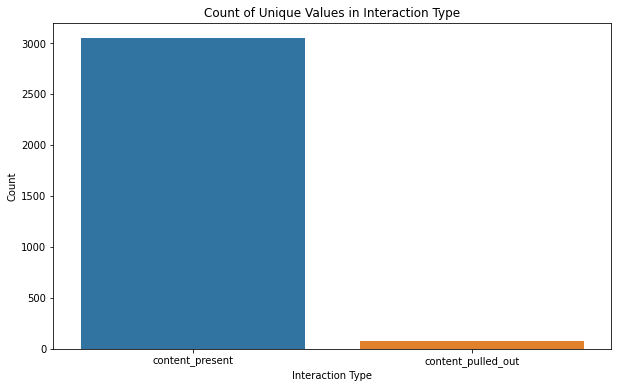

In [130]:
# Plot counts of unique values for 'interaction_type'
plt.figure(figsize=(10, 6))
sns.countplot(x='interaction_type', data=news, order=news['interaction_type'].value_counts().index)
plt.title('Count of Unique Values in Interaction Type')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.show()

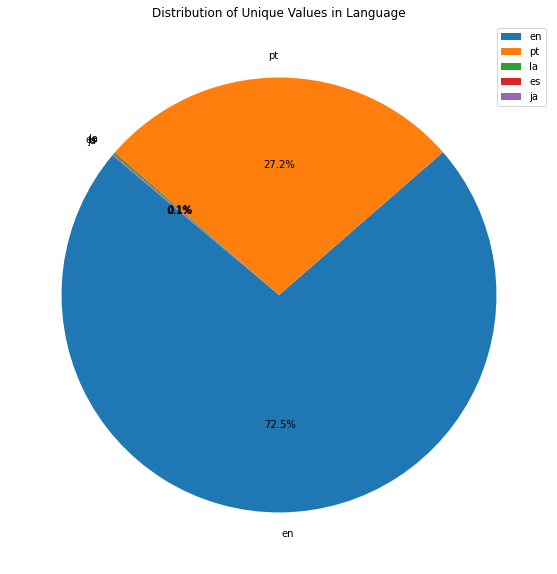

In [131]:
plt.figure(figsize=(10, 10))

# Calculate value counts for 'language'
language_counts = news['language'].value_counts()

# Plot a pie chart
patches, texts, autotexts = plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)

# Add a legend
plt.legend(patches, language_counts.index, loc="best")

plt.title('Distribution of Unique Values in Language')
plt.show()

We observe that most of the news is in English

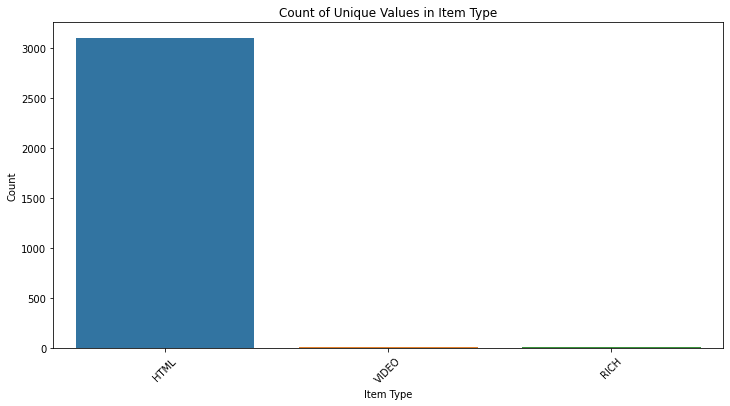

In [132]:
# Plot counts of unique values for 'item_type'
plt.figure(figsize=(12, 6))
sns.countplot(x='item_type', data=news, order=news['item_type'].value_counts().index)
plt.title('Count of Unique Values in Item Type')
plt.xlabel('Item Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

We observe that almost all the news is text based

## Preprocessing on content data
Since we will be dealing mainly with English articles, let us only take them. Also, let's take only the present articles for consideration

In [133]:
news_all_cols = news[(news['language'] == 'en')&(news['interaction_type']=='content_present')]

In [134]:
print(news_all_cols.item_id.nunique())
print(news_all_cols.item_id.apply(abs).nunique())

2211
2211


In [135]:
# Which implies that we can keep the absolute values of ids
news_all_cols.item_id = news_all_cols.item_id.apply(abs)


C:\Users\vssashar\AppData\Local\Temp\ipykernel_18488\2029350483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_all_cols.item_id = news_all_cols.item_id.apply(abs)


In [136]:
news = news_all_cols[['item_id', 'title']]

In [137]:
news.head()

,item_id,title
1,4110354420726924665,"Ethereum, a Virtual Currency, Enables Transact..."
2,7292285110016212249,Bitcoin Future: When GBPcoin of Branson Wins O...
3,6151852268067518688,Google Data Center 360° Tour
4,2448026894306402386,"IBM Wants to ""Evolve the Internet"" With Blockc..."
5,2826566343807132236,IEEE to Talk Blockchain at Cloud Computing Oxf...


In [138]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2211 entries, 1 to 3121
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_id  2211 non-null   int64 
 1   title    2211 non-null   object
dtypes: int64(1), object(1)
memory usage: 51.8+ KB


In [139]:
news.nunique()

item_id    2211
title      2173
dtype: int64

In [140]:
news.dtypes

item_id     int64
title      object
dtype: object

# Content Based Recommendations

In [141]:
# movies_keywords = pd.read_csv('')
news_all_cols.head()


,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
1,1459193988,content_present,4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,content_present,2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [142]:
news_all_cols.columns

Index(['event_timestamp', 'interaction_type', 'item_id', 'producer_id',
       'producer_session_id', 'producer_device_info', 'producer_location',
       'producer_country', 'item_type', 'item_url', 'title',
       'text_description', 'language'],
      dtype='object')

In [143]:
new_keywords = news_all_cols[['title', 'text_description']]

## Preprocess the text_description
We will remove away all the stop words and lemmatize text to make tfidf work at its best

In [144]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Download the stopwords dataset (only need to do this once)
nltk.download('stopwords');
# Download the WordNet dataset (only need to do this once)
nltk.download('wordnet');

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vssashar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vssashar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [145]:

# Function to remove stopwords from a sentence
def remove_stopwords(sentence):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(sentence)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(sentence)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

In [146]:
news_all_cols['text_description'] = news_all_cols['text_description'].apply(lambda x: lemmatize_sentence(remove_stopwords(x)))

## convert to numpy arrays

In [147]:
keywords_array = news_all_cols['text_description'].to_numpy()

In [151]:
keywords_array[0]

"work still early . first full public version Ethereum software recently released , system could face technical legal problem tarnished Bitcoin . Many Bitcoin advocate say Ethereum face security problem Bitcoin greater complexity software . Thus far , Ethereum faced much le testing , many fewer attack , Bitcoin . novel design Ethereum may also invite intense scrutiny authority given potentially fraudulent contract , like Ponzi scheme , written directly Ethereum system . sophisticated capability system made fascinating executive corporate America . IBM said last year experimenting Ethereum way control real world object so-called Internet thing . Microsoft working several project make easier use Ethereum computing cloud , Azure . `` Ethereum general platform solve problem many industry using fairly elegant solution - elegant solution seen date , `` said Marley Gray , director business development strategy Microsoft . Mr. Gray responsible Microsoft 's work blockchains , database concept B

## Split keywords & create word list

In [152]:
words_list = []

for keyword in keywords_array:
    
    splitted_words = str(keyword).lower().split()
    
    words_list.append(splitted_words)

## Create Dictionary, BOW, tfidf model & Similarity Matrix

In [155]:
from gensim.corpora.dictionary import Dictionary

# create a dictionary from words list
dictionary = Dictionary(words_list) 

#create corpus where the corpus is a bag of words for each document
corpus = [dictionary.doc2bow(doc) for doc in words_list] 

from gensim.models.tfidfmodel import TfidfModel
#create tfidf model of the corpus
tfidf = TfidfModel(corpus) 

from gensim.similarities import MatrixSimilarity
# Create the similarity matrix. This is the most important part where we get the similarities between the movies.
sims = MatrixSimilarity(tfidf[corpus], num_features=len(dictionary))


In [156]:
print(sims)

MatrixSimilarity<2211 docs, 58053 features>


## For an input movie, Run the Model & return Recommended Movies

In [157]:
def news_recommendation(item_id):
    # get the item row
    item = news_all_cols.loc[news_all_cols.item_id == item_id] 
    
    # split the keywords
    keywords = item['text_description'].iloc[0].split() 

    # set the list of words to query_doc
    query_doc = keywords 
    
    # get a bag of words from the query_doc
    query_doc_bow = dictionary.doc2bow(query_doc) 

    # convert the regular bag of words model to a tf-idf model
    query_doc_tfidf = tfidf[query_doc_bow] 

    # get similarity values between input item and all other items
    similarity_array = sims[query_doc_tfidf] 

    # Convert to a Series
    similarity_series = pd.Series(similarity_array.tolist(), index=news_all_cols.item_id.values) 

    # Exclude the queried item
    similarity_series = similarity_series[similarity_series.index != item_id]
    
    # get the most similar items 
    similarity_output = similarity_series.sort_values(ascending=False)
    return similarity_output


In [158]:
item_id_to_recommend_for = 4333957157636611418
content_output = news_recommendation(item_id_to_recommend_for)
content_df = pd.DataFrame(content_output)
content_df.reset_index(inplace=True)
content_df.columns = ['item_id', 'score']
content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))
item_recommendation_content = pd.merge(content_df,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')

In [159]:
item_tile = news[news.item_id==item_id_to_recommend_for].title.iloc[0]
print(f'Top 10 items similar to item {item_id_to_recommend_for}, titled \'{item_tile}\':')
item_recommendation_content.head(10)

Top 10 items similar to item 4333957157636611418, titled 'Why Programmers Want Private Offices':


,item_id,score,content_score_normalized,title
0,7876497512693688413,0.172471,1.000000,The Joel Test: 12 Steps to Better Code
1,4996336942690402156,0.148833,0.862943,Live asynchronously.
2,8800029253812071912,0.141837,0.822379,Facebook Workplace officially launches on the ...
3,4463029741564307314,0.130018,0.753852,Dries Buytaert
4,5271205718596251417,0.124863,0.723960,9 Rules of Open-Office Etiquette
5,7424795099560672335,0.123945,0.718640,7 Tips to Create a Company Learning Culture li...
6,5270696484536580646,0.116575,0.675906,8 Insanely Simple Productivity Hacks
7,489290927107045539,0.114735,0.665239,Research: Why Best Practices Don't Translate A...
8,6377566860234930618,0.107520,0.623405,How to Create a Unified Culture in a Company W...
9,4644672909721737325,0.105483,0.611591,Automation and anxiety


Observe how all the suggested articles areg about work places and workplace culture, which is the domain of the queried article

# Hybrid models for item-user based recommendations

## UBCF + IBCF

In [160]:
def hybrid_ubfc_ibfc(consumer_id,item_id, k = 10, alpha = 0.8):
    #UBFC
    item_recommendation_ubcf = user_final_rating.loc[consumer_id].sort_values(ascending = False)
    item_recommendation_ubcf = pd.merge(item_recommendation_ubcf,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
    item_recommendation_ubcf.columns = ['item_id','score','title']

    # Min-Max Scaling
    min_score = min(item_recommendation_ubcf['score'])
    max_score = max(item_recommendation_ubcf['score'])

    normalized_ubcf_scores = (item_recommendation_ubcf['score'] - min_score) / (max_score - min_score)

    item_recommendation_ubcf['normalized_ubfc_score'] = normalized_ubcf_scores


    # Filter item_recommendation to include only items not in the ratings for the specified consumer_id
    item_recommendation_ubcf = item_recommendation_ubcf[~item_recommendation_ubcf.index.isin(ratings[ratings['consumer_id'] == consumer_id]['item_id'])]

    
    #IBFC
    
    item_id_to_recommend_for = item_id
    
    # If we find the item in our training dataset, all well and good.
    # But what if we are dealing with a brand new item absent in training?
    # For this reason, we do a quick search
    data_matrix_search = data_matrix_train
    if item_id in set(data_matrix_test.columns) - set(data_matrix_train.columns) :
        data_matrix_search = data_matrix_test
        
        
    #item_recommendation_ibfc = recommend_similar_items(item_similarity_df, item_id_to_recommend_for, top_n=-1)
    item_recommendation_ibfc = recommend_similar_items_2(item_id_to_recommend_for,data_matrix_train,data_matrix_search, top_n=-1)
    
    item_recommendation_ibfc = pd.merge(item_recommendation_ibfc,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
    item_recommendation_ibfc.columns = ['item_id','score','title']
    
    # Filter item_recommendation to include only items not in the ratings for the specified consumer_id
    item_recommendation_ibfc = item_recommendation_ibfc[~item_recommendation_ibfc.index.isin(ratings[ratings['consumer_id'] == consumer_id]['item_id'])]

    

    # Min-Max Scaling
    min_score = min(item_recommendation_ibfc['score'])
    max_score = max(item_recommendation_ibfc['score'])

    normalized_ibcf_scores = (item_recommendation_ibfc['score'] - min_score) / (max_score - min_score)

    item_recommendation_ibfc['normalized_ibfc_score'] = normalized_ibcf_scores

    hybrid_output = pd.merge(item_recommendation_ubcf[['item_id','normalized_ubfc_score','title']],item_recommendation_ibfc[['item_id','normalized_ibfc_score']], how='left', on='item_id').fillna(0)
    
    hybrid_output['final_score'] = ((1-alpha)*hybrid_output['normalized_ibfc_score'] + alpha*hybrid_output['normalized_ubfc_score'])
    
    # Min-Max Scaling
    min_score = np.min(hybrid_output['final_score'])
    max_score = np.max(hybrid_output['final_score'])
    
    hybrid_output['normalized_ubcf_ibcf_score'] = (hybrid_output['final_score'] - min_score) / (max_score - min_score)
    
    return hybrid_output.sort_values(by='normalized_ubcf_ibcf_score',ascending = False).reset_index().head(k)

In [161]:
consumer_id = 9207251133131336884
item_id = 4333957157636611418
item_tile = news_all_cols[news_all_cols.item_id==item_id].title.iloc[0]
hybrid_ubfc_ibfc_recommendation = hybrid_ubfc_ibfc(consumer_id = consumer_id,item_id = item_id,alpha=0.8)

In [162]:
print(f'For consumer_id: {consumer_id}, we recommend the following articles similar to \'{item_tile}\'')
hybrid_ubfc_ibfc_recommendation

For consumer_id: 9207251133131336884, we recommend the following articles similar to 'Why Programmers Want Private Offices'


,index,item_id,normalized_ubfc_score,title,normalized_ibfc_score,final_score,normalized_ubcf_ibcf_score
0,0,5338677278233757627,1.000000,How to Get a Job at Google,0.0,0.800000,1.000000
1,1,8208801367848627943,0.609710,Ray Kurzweil: The world isn't getting worse - ...,0.0,0.487768,0.609710
2,2,759389978085260161,0.596239,Top 30 Commonly Confused Words in English,0.0,0.476991,0.596239
3,3,8992803137960175254,0.586392,4 Reasons Managers Should Spend More Time on C...,0.0,0.469114,0.586392
4,4,5605799891597699962,0.508539,Concrete things you can do about your technica...,0.0,0.406832,0.508539
5,5,7516228655554309785,0.482850,A digital crack in banking's business model,0.0,0.386280,0.482850
6,6,5002383425685129595,0.458956,Changing change management,0.0,0.367165,0.458956
7,7,8627051188605351707,0.438603,When to make a Git Commit,0.0,0.350883,0.438603
8,8,7088167897470452815,0.426076,"Life Coach vs. Therapist, Learn the Difference...",0.0,0.340861,0.426076
9,9,6340141548068597572,0.413738,Top 10 Insurtech Trends for 2017 - Insurance T...,0.0,0.330991,0.413738


## Content + UBCF + IBCF

In [163]:
def hybrid_ubcf_ibcf_content(consumer_id,item_id, alpha = 0.8, beta = 0.4, k = 10):
    
    
    #UBCF- IBCF
    hybrid_ubfc_ibfc_recommendation = hybrid_ubfc_ibfc(consumer_id = consumer_id,item_id = item_id, alpha = alpha , k = k)

    hybrid_ubfc_ibfc_recommendation = hybrid_ubfc_ibfc_recommendation[~hybrid_ubfc_ibfc_recommendation.index.isin(ratings[ratings['consumer_id'] == consumer_id]['item_id'])]

    
    
    ## Content based
    content_output = news_recommendation(item_id)
    content_df = pd.DataFrame(content_output)
    content_df.reset_index(inplace=True)
    content_df.columns = ['item_id', 'score']
    content_df['content_score_normalized'] = (content_df['score']-min(content_df['score'])) / (max(content_df['score']) - min(content_df['score']))
    item_recommendation_content = pd.merge(content_df,news[['item_id','title']],left_on = 'item_id',right_on = 'item_id',how = 'left')
    
    # Filter item_recommendation to include only items not in the ratings for the specified consumer_id
    item_recommendation_content = item_recommendation_content[~item_recommendation_content.index.isin(ratings[ratings['consumer_id'] == consumer_id]['item_id'])]

    
    hybrid_output = pd.merge(hybrid_ubfc_ibfc_recommendation[['item_id','normalized_ubcf_ibcf_score','title']],item_recommendation_content[['item_id','content_score_normalized']], how='left', on='item_id').fillna(0)
    
    hybrid_output['final_score'] = beta*hybrid_output['normalized_ubcf_ibcf_score'] + (1-beta)*hybrid_output['content_score_normalized'] 

    
    # Min-Max Scaling
    min_score = np.min(hybrid_output['final_score'])
    max_score = np.max(hybrid_output['final_score'])
    
    hybrid_output['normalized_final_score'] = (hybrid_output['final_score'] - min_score) / (max_score - min_score)
    
    return hybrid_output.sort_values(by='final_score',ascending = False).reset_index().head(k)

In [164]:
consumer_id = 9207251133131336884
item_id =  4333957157636611418
item_tile = news_all_cols[news_all_cols.item_id==item_id].title.iloc[0]
hybrid_ubcf_ibcf_content_recommendation = hybrid_ubcf_ibcf_content(consumer_id = consumer_id,item_id = item_id,alpha=0.8,beta=0.4)

In [165]:
print(f'For consumer_id: {consumer_id}, we recommend the following articles similar to \'{item_tile}\'')
hybrid_ubcf_ibcf_content_recommendation

For consumer_id: 9207251133131336884, we recommend the following articles similar to 'Why Programmers Want Private Offices'


,index,item_id,normalized_ubcf_ibcf_score,title,content_score_normalized,final_score,normalized_final_score
0,0,5338677278233757627,1.000000,How to Get a Job at Google,0.271444,0.562866,1.000000
1,6,5002383425685129595,0.458956,Changing change management,0.452178,0.454889,0.691609
2,5,7516228655554309785,0.482850,A digital crack in banking's business model,0.260639,0.349523,0.390676
3,1,8208801367848627943,0.609710,Ray Kurzweil: The world isn't getting worse - ...,0.166045,0.343511,0.373504
4,9,6340141548068597572,0.413738,Top 10 Insurtech Trends for 2017 - Insurance T...,0.273090,0.329349,0.333056
5,3,8992803137960175254,0.586392,4 Reasons Managers Should Spend More Time on C...,0.150707,0.324981,0.320580
6,4,5605799891597699962,0.508539,Concrete things you can do about your technica...,0.167435,0.303877,0.260305
7,2,759389978085260161,0.596239,Top 30 Commonly Confused Words in English,0.066526,0.278411,0.187573
8,7,8627051188605351707,0.438603,When to make a Git Commit,0.123658,0.249636,0.105389
9,8,7088167897470452815,0.426076,"Life Coach vs. Therapist, Learn the Difference...",0.070509,0.212736,0.000000


### Why should we give less weightage to user-based component in the hybrid model

Recommending articles based on current article would theoretically best be achieved when higher weightage is given to content-based and item-based, over user-based, since here we are trying to deep dive specifically into fetching articles similar to the current one, rather than general list of articles the user would like.

Moreover, this way, the user will be less likely to circle around the same genre of articles they have been reading. It gives some scope for freshness in what they consume.

### # Important note
#### The code segments that follow take reasonable amount of time to execute. Please be patient.

## Global precision @ k for our hybrid model

Here, we take precision@k for every consumer-item combination in the test dataset and average it

In [166]:
def global_precision_at_k_hybrid(test_data, hybrid_recommender, k=10, min_interaction_type = 'content_liked'):
    """
    Compute the global precision@k for a hybrid recommender system.

    Parameters:
    - test_data (DataFrame): Test dataset containing item interactions.
    - hybrid_recommender (function): Hybrid recommender function.
    - k (int): Number of top-k recommendations to consider.

    Returns:
    - global_precision (float): Global precision@k.
    """
    total_users = len(test_data['consumer_id'].unique())
    total_precision = 0
    total_cases = len(test_data)

    for consumer_id in test_data['consumer_id'].unique():

        # Get actual items interacted by the user
        actual_items = test_data[test_data['consumer_id'] == consumer_id]['item_id'].values
        ratings_filtered = ratings[(ratings['consumer_id']==consumer_id) & (ratings['rating']>=interaction_2_rating[min_interaction_type])]
        all_items_by_consumer = ratings_filtered['item_id'].values
        for item_id in actual_items:

            # Get top-k recommendations from the hybrid recommender
            recommendations = hybrid_recommender(consumer_id, item_id, k=k)['item_id'].values

            relevant_set = set(filter(lambda x: x != item_id, all_items_by_consumer))
            # Calculate precision@k for the user
            precision_at_k = len(relevant_set & set(recommendations)) / k if k > 0 else 0

            total_precision += precision_at_k


    # Calculate global precision@k
    global_precision = total_precision / total_cases if total_cases > 0 else 0

    return global_precision


Before we run the test, let us only look at test case consumers with more than 200 recommendations, since it would otherwise lead to low precisions

In [167]:
# Group by 'consumer_id' and count the number of unique 'item_id'
consumer_item_counts = train.groupby('consumer_id')['item_id'].nunique()

# Filter consumers with more than 100 unique items
consumers_with_more_than_200_items = consumer_item_counts[consumer_item_counts >= 200].index.tolist()

# Print the list of consumer_ids
print(consumers_with_more_than_200_items)

[692689608292948411, 1032019229384696495, 1116121227607581999, 1443636648652872475, 2416280733544962613, 2626634673110551643, 2979881261169775358, 3596626804281480007, 3609194402293569455, 3636910968448833585]


In [168]:
# Filter the 'test' DataFrame based on consumer_ids with more than 100 unique items
test_200 = test[test['consumer_id'].isin(consumers_with_more_than_200_items)]


In [169]:
test_200.shape

(766, 3)

In [170]:
# Running on Test data
precision_at_10_hybrid_200 = global_precision_at_k_hybrid(test_200, hybrid_ubcf_ibcf_content, k=10)
print(f"Global Precision@10 for Hybrid Recommender for users with more than 200 titles read =  {precision_at_10_hybrid_200}")

Global Precision@10 for Hybrid Recommender for users with more than 200 titles read =  0.13603133159268901


This particular evaluation has multiple issues
1. It took a very long time to compute, despite the sharp filter downs
2. The value is pretty low, owing to the very low ratio of articles read to total articles

Let us try to measure the hitrate instead.

## Hit-rate
Here, we take Hitrate@k for every consumer-item combination in the test dataset and average it

In [171]:
def hit_rate_at_k_hybrid(test_data, hybrid_recommender, k=10, min_interaction_type='content_liked'):
    """
    Compute the hit rate@k for a hybrid recommender system.

    Parameters:
    - test_data (DataFrame): Test dataset containing item interactions.
    - hybrid_recommender (function): Hybrid recommender function.
    - k (int): Number of top-k recommendations to consider.

    Returns:
    - hit_rate (float): Hit rate@k.
    """
    total_users = len(test_data['consumer_id'].unique())
    total_hits = 0
    total_cases = len(test_data)

    for consumer_id in test_data['consumer_id'].unique():
        # Get actual items interacted by the user
        actual_items = test_data[test_data['consumer_id'] == consumer_id]['item_id'].values
        ratings_filtered = ratings[(ratings['consumer_id'] == consumer_id) & (ratings['rating'] >= interaction_2_rating[min_interaction_type])]
        all_items_by_consumer = ratings_filtered['item_id'].values

        for item_id in actual_items:
            # Get top-k recommendations from the hybrid recommender
            recommendations = hybrid_recommender(consumer_id, item_id, k=k)['item_id'].values

            relevant_set = set(filter(lambda x: x != item_id, all_items_by_consumer))
            
            # Check if there is a hit (at least one recommended item is in the relevant set)
            hit = any(item in relevant_set for item in recommendations[:k])

            total_hits += int(hit)

    # Calculate hit rate@k
    hit_rate = total_hits / total_cases if total_cases > 0 else 0

    return hit_rate


In [172]:
# Running on filtered down Test data
hit_rate_at_10_200 = hit_rate_at_k_hybrid(test_200, hybrid_ubcf_ibcf_content, k=10)
print(f"Hit Rate@10 for Hybrid Recommender for users with more than 200 titles read = {100*hit_rate_at_10_200}/%")

Hit Rate@10 for Hybrid Recommender for users with more than 200 titles read = 70.36553524804178/%


### This implies that for users who read more than 200 articles, about 70% of the times, they click through and atleast like the article we recommend based on their current read

#### What about our majority reader?
During EDA, we saw how most of our consumers read less than 10 articles. Let us look at the hitrate of this category, but this time, for a generalized hit per consumer

In [173]:
# Filter consumers with more than 100 unique items
consumers_with_less_than_10_items = consumer_item_counts[consumer_item_counts <= 10].index.tolist()
# Filter the 'test' DataFrame based on consumer_ids with less than 10 unique items
test_10 = test[test['consumer_id'].isin(consumers_with_less_than_10_items)]

In [174]:
# Running on filtered down Test data
hit_rate_at_10_10 = hit_rate_at_k_hybrid(test_10, hybrid_ubcf_ibcf_content, k=10)
print(f"Hit Rate@10 for Hybrid Recommender for users with less than 10 titles read = {100*hit_rate_at_10_10}/%")

Hit Rate@10 for Hybrid Recommender for users with less than 10 titles read = 3.508771929824561/%


In [175]:
print(f'total count of unique titles ratings = {ratings.item_id.nunique()}')

total count of unique titles ratings = 2149


That's a very low hitrate per consumer-item combination. But this is due to the very small ratio of total titles read to total titles online. It would be a very rare incident to hit the other 9 articles from a pool of 2149. Even if we take the count of relevant recommendations to be about 100 for each article, that woulf still be less that 10% odds.

## Observation
From observation of individual recommendations, we saw that the recommendations are decently close to the the current reading articles. But we have been observing exceptionally low hitrates for consumers who have consumed very few articles.

This may not be due to less reads. The issue is with our evaluation method. Offline techniques for evaluation would have very rare propensity to hit right, especially when the documents in history are much much lower than our total items.

Online evaluation techniques can better tell us in real time, with better clarity, if our algorithm is helpful, since we can observe the impact of our recommendations directly.


# Online Evaluation

For the second problem statement, which involves recommending similar news articles and assessing the performance of the recommendation system, online evaluation techniques play a crucial role. Unlike traditional offline evaluation metrics used in batch processing, online evaluation involves real-time assessment of user interactions with the system. Here are some relevant online evaluation techniques:

## 1. A/B Testing:

- **Description:** A/B testing involves comparing two versions (A and B) of a recommendation algorithm to determine which performs better.
- **Implementation:** Randomly assign users to different groups (A and B) and expose them to different recommendation algorithms.
- **Metrics:** Compare metrics like click-through rate (CTR), conversion rate, and engagement to evaluate the effectiveness of the recommendation models.

## 2. Online User Surveys:

- **Description:** Collect feedback from users about the relevance and satisfaction of the recommended articles in real-time.
- **Implementation:** Integrate short surveys or feedback forms within the application.
- **Metrics:** Analyze user responses to assess the perceived quality of recommendations.

## 3. Click-Through Rate (CTR):

- **Description:** Measure the ratio of users who click on a recommended article to the total number of users who view the recommendation.
- **Implementation:** Track the number of clicks on recommended articles in real-time.
- **Metrics:** CTR provides insights into the effectiveness of recommendations in attracting user interest.

## 4. Feedback Loops:

- **Description:** Establish a continuous feedback loop where user interactions and feedback are used to update and refine the recommendation models.
- **Implementation:** Collect user feedback on recommended articles and use it to iteratively improve the models.
- **Metrics:** Evaluate the impact of model updates on user satisfaction and engagement.

## 5. Incremental Metrics:

- **Description:** Monitor incremental metrics such as user retention and user engagement over time.
- **Implementation:** Track changes in user behavior and system performance after implementing new recommendation strategies.
- **Metrics:** Assess whether the recommendations contribute positively to long-term user engagement.

## 6. Diversity and Novelty Metrics:

- **Description:** Evaluate the diversity and novelty of recommended articles to ensure a broad range of topics and prevent content fatigue.
- **Implementation:** Use metrics like diversity@k and novelty to measure the variety and freshness of recommendations.
- **Metrics:** Ensure that recommendations avoid repetitive content and introduce users to new and diverse topics.

## 7. Latency and Throughput:

- **Description:** Assess the system's response time (latency) and the number of recommendations it can generate per unit time (throughput).
- **Implementation:** Monitor the time it takes to generate recommendations and deliver them to users.
- **Metrics:** Optimize latency and throughput to enhance the user experience.

## 8. Session-based Metrics:

- **Description:** Evaluate the performance of the recommendation system in the context of user sessions.
- **Implementation:** Consider metrics like session-based precision, recall, and diversity.
- **Metrics:** Assess how well the system understands and satisfies users' preferences within a single session.

Implementing a combination of these online evaluation techniques provides a comprehensive understanding of the recommendation system's effectiveness in real-world scenarios. Continuous monitoring and adaptation based on user feedback are essential for maintaining and improving the system's performance over time.
